Epoch 1/20


/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


121/121 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.0086
Epoch 2/20
121/121 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0034
Epoch 3/20
121/121 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0039
Epoch 4/20
121/121 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0020
Epoch 5/20
121/121 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0012
Epoch 6/20
121/121 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0021
Epoch 7/20
121/121 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0014
Epoch 8/20
121/121 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 9.3168e-04
Epoch 9/20
121/121 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 9.9267e-04
Epoch 10/20
121/121 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 7.9559e-04
Epoch 11/20
121/121 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0021
Epoch 12/20
121/121 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0018
Epoch 13/20
121/121 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0016
Epoch 14/20
121/121 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 6.0830e-04
Epoch 15/20
121/121 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step

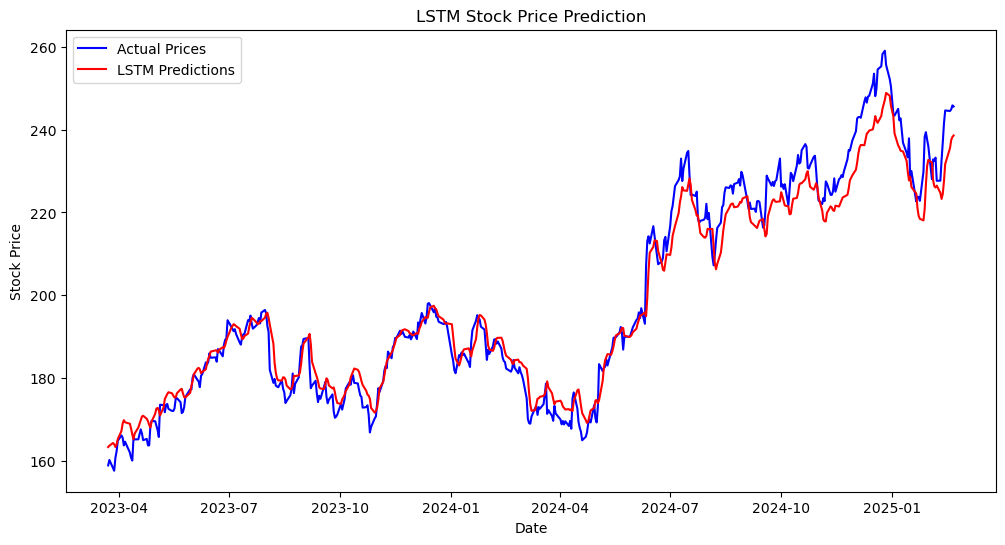

In [2]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt

# Load dataset
df = pd.read_csv("AAPL_final_merged.csv")

# Ensure dates are in datetime format and sort the dataset
df["Date_x"] = pd.to_datetime(df["Date_x"])
df = df.sort_values("Date_x")

# Use only the closing price for time-series forecasting
closing_prices = df["close_x"].values.reshape(-1, 1)

# Normalize the closing price for better performance
scaler = MinMaxScaler(feature_range=(0, 1))
closing_prices_scaled = scaler.fit_transform(closing_prices)

# Function to create time-series sequences for LSTM
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i + seq_length])
        y.append(data[i + seq_length])
    return np.array(X), np.array(y)

# Define sequence length (how many past days to use for prediction)
sequence_length = 10  # Using 10 days of past prices

# Create LSTM input sequences
X_lstm, y_lstm = create_sequences(closing_prices_scaled, sequence_length)

# Split into training (80%) and testing (20%) sets
train_size = int(len(X_lstm) * 0.8)
X_train_lstm, X_test_lstm = X_lstm[:train_size], X_lstm[train_size:]
y_train_lstm, y_test_lstm = y_lstm[:train_size], y_lstm[train_size:]

# Build the LSTM model
lstm_model = Sequential([
    LSTM(units=50, return_sequences=True, input_shape=(sequence_length, 1)),
    Dropout(0.2),
    LSTM(units=50, return_sequences=False),
    Dropout(0.2),
    Dense(units=25),
    Dense(units=1)
])

# Compile the model
lstm_model.compile(optimizer='adam', loss='mean_squared_error')

# Train the LSTM model
lstm_model.fit(X_train_lstm, y_train_lstm, epochs=20, batch_size=16, verbose=1)

# Make predictions
y_pred_lstm = lstm_model.predict(X_test_lstm)

# Inverse transform predictions and actual values back to original scale
y_pred_lstm_actual = scaler.inverse_transform(y_pred_lstm)
y_test_lstm_actual = scaler.inverse_transform(y_test_lstm.reshape(-1, 1))

# Compute evaluation metrics
lstm_r2 = r2_score(y_test_lstm_actual, y_pred_lstm_actual)
lstm_mse = mean_squared_error(y_test_lstm_actual, y_pred_lstm_actual)
lstm_mae = mean_absolute_error(y_test_lstm_actual, y_pred_lstm_actual)

# Display results
print(f"LSTM R² Score: {lstm_r2:.4f}")
print(f"LSTM MSE: {lstm_mse:.4f}")
print(f"LSTM MAE: {lstm_mae:.4f}")

# Plot actual vs predicted prices (Fixing misalignment)
plt.figure(figsize=(12, 6))
plt.plot(df["Date_x"][train_size + sequence_length:], y_test_lstm_actual, label="Actual Prices", color="blue")
plt.plot(df["Date_x"][train_size + sequence_length:], y_pred_lstm_actual, label="LSTM Predictions", color="red")
plt.xlabel("Date")
plt.ylabel("Stock Price")
plt.title("LSTM Stock Price Prediction")
plt.legend()
plt.show()
